In [1]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecVideoRecorder
from two_room_env import TwoRoomEnv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from stable_baselines3 import PPO
from cnn import MinigridFeaturesExtractor
from stable_baselines3.common.utils import obs_as_tensor

pygame 2.5.2 (SDL 2.28.3, Python 3.9.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# For 2 Room fully observable
config = {
    "policy_type": "CnnPolicy",
    "total_timesteps": 5e5,
    "env_name": "Two-Room",
    "feat_dim":8,
}

In [3]:
# load agent
model = PPO.load("/Users/kevinroice/Documents/research/discovery/models/tf5hze1v/model")

In [4]:
def make_env():
    env = TwoRoomEnv(render_mode="rgb_array")
    env = FullyObsWrapper(env)
    env = ImgObsWrapper(env)
    env = Monitor(env)
    return env

def pre_process_obs(obs, model):
    obs = np.transpose(obs, (0,3,1,2)) # bring colour channel to front
    return obs_as_tensor(obs, model.policy.device)

In [5]:
# env = DummyVecEnv([make_env])
env = DummyVecEnv([make_env])
obs = env.reset()

In [71]:
def get_hallway_obs(env, see_obs=False):
    # # Vector Action Encoding:
    # 0 = left
    # 1 = right
    # 2 = forward
    obs = env.reset() # initial obs
    obs_list = []
    for i in range(5):
        obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    for i in range(2):
        obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    # obs_list.append(obs)

    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    # Turn around and leave the 2nd room
    # obs, _, _, _ = env.step([0])
    # obs, _, _, _ = env.step([0])
    # obs_list.append(obs)

    # obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    # obs, _, _, _ = env.step([2])
    # obs_list.append(obs)

    # Go to goal - comment out the above one
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs_list.append(obs)

    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([1])
    obs_list.append(obs)

    obs, _, _, _ = env.step([1])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    obs, _, _, _ = env.step([2])
    obs, _, _, _ = env.step([0])
    obs_list.append(obs)   
    
    if see_obs:
        img = env.render()
        plt.imshow(np.concatenate([img], 1)) # shows the full environment
        plt.show()
    
    return obs_list

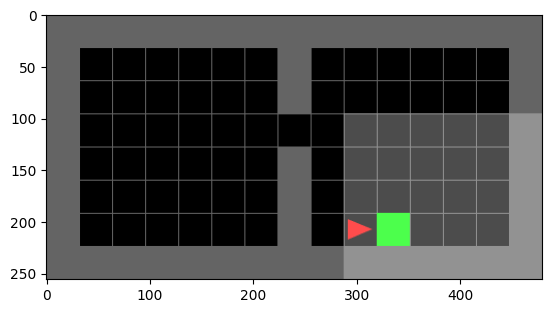

[array([[[[ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0],
          [ 2,  5,  0]],
 
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
 
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
 
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
 
         [[ 2,  5,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 1,  0,  0],
          [ 2,  5,  0]],
 
         [[ 2,  5,  0],
 

In [72]:
get_hallway_obs(env, see_obs=True)

In [63]:
obs_list = get_hallway_obs(env, see_obs=False)
max_feat_list = []
feature_activations = []

with torch.no_grad():
    for obs in obs_list:
        obs = pre_process_obs(obs, model)
        x = model.policy.extract_features(obs)
        max_feat_list.append(torch.argmax(x).item())
        feature_activations.append(x.reshape(1, -1))

feature_activations = torch.cat(feature_activations, dim=0)

In [ ]:
max_feat_list

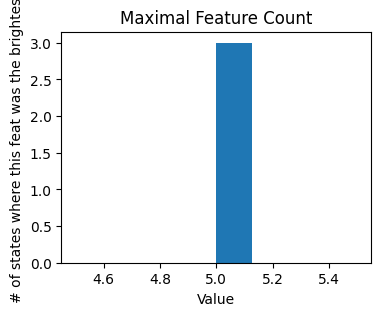

In [64]:
plt.figure(figsize=(4, 3))
plt.hist(max_feat_list, bins=config["feat_dim"])
plt.xlabel('Value')
plt.ylabel('# of states where this feat was the brightest')
plt.title('Maximal Feature Count')
plt.show()

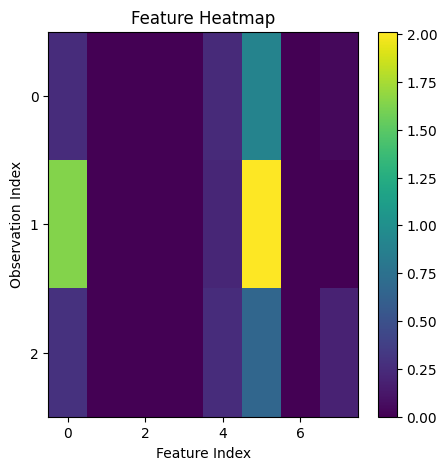

In [66]:
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.imshow(feature_activations, cmap='viridis', aspect='auto')
# y_tick_positions = [i * 56 for i in range(785 // 56)] # 16 by 16
# y_tick_positions = [i * 12 for i in range(36 // 12)]
plt.yticks([0,1,2])
plt.colorbar()
plt.xlabel('Feature Index')
plt.ylabel('Observation Index')
plt.title('Feature Heatmap')
plt.show()

In [ ]:
downs = []
lefts = []
ups = []
rights = []
titles = ["Down", "Left", "Up", "Right"]
grid_size = 3

# store the feature vectors based on the direction the agent was pointing 
for i in range(feature_activations.size(0)):
    feat_vec = feature_activations[i,:]
    if i % 4 == 0:
        downs.append(feat_vec)
    elif i % 4 == 1:
        lefts.append(feat_vec)
    elif i % 4 == 2:
        rights.append(feat_vec)
    elif i % 4 == 3:
        ups.append(feat_vec)

all_feats = [downs, lefts, ups, rights]
top_k = 4
# grid = np.zeros((grid_size, grid_size, top_k))
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for j, ax in enumerate(axes.flat):
    grid = np.zeros((grid_size, grid_size, top_k))
    for i, vector in enumerate(all_feats[j]):
        row, col = divmod(i, grid_size)  # Calculate the row and column for the current subplot

        # Get the indices of the top 'n' entries
        # highest_value = torch.argmax(vector)
        highest_value = torch.topk(vector, k=top_k).indices
        # print(highest_value)
        grid[row, col, :] = highest_value


    # Create a 3x3 grid plot
    ax.axis('off')
    cax = ax.imshow([[1, 1, 1], [1, 1, 1], [1, 1, 1]], interpolation='none', cmap='gray')
    # Add text labels with the highest values
    for i_ in range(3):
        for j_ in range(3):
            ax.text(j_, i_, f'{grid[i_, j_]}', va='center', ha='center', color='white')

    ax.set_title(titles[j]) 
plt.tight_layout()
plt.show()
    